In [1]:
%matplotlib qt5

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import mne_bids 
import mne_bids.utils 
import pandas as pd
from fooof import FOOOF,FOOOFGroup

In [3]:
deriv_bids_root = '/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS'
mne_bids.print_dir_tree(deriv_bids_root, max_depth=4)

|Derivatives_Proyecto_LFA-ENYS_BIDS/
|--- README
|--- Referencias_guia_tener_en_cuenta.odt
|--- dataset_description.json
|--- participants.json
|--- participants.tsv
|--- sub-06/
|------ ses-day1/
|--------- sub-06_ses-day1_scans.tsv
|--------- ieeg/
|------------ sub-06_ses-day1_selectedChannels.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_channels.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_events.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_ieeg.edf
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm1_ieeg.json
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm2_channels.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm2_events.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm2_ieeg.edf
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm2_ieeg.json
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm3_channels.tsv
|------------ sub-06_ses-day1_task-msl_desc-baselineSegm3_events.tsv
|-------

In [4]:
session = 'day1'
datatype = 'ieeg'
subjects = mne_bids.get_entity_vals(deriv_bids_root, 'subject')
tasks = mne_bids.get_entity_vals(deriv_bids_root, 'task')
suffix = 'ieeg'

# Indicar el codigo de descripcion del archivo 'desc'
desc_posible = ['baselineSegm1', 'baselineSegm2', 'baselineSegm3','ctrTask','secTask']
#desc = desc_posible[0]

print(mne_bids.get_entity_vals(deriv_bids_root, 'subject'))
print(mne_bids.get_entity_vals(deriv_bids_root, 'task'))
print(mne_bids.get_entity_vals(deriv_bids_root, 'session'))
#print(desc)


['06', '07']
['msl']
['day1']


In [8]:
idx_sub = 0 # Indice del sujeto analizado
idx_task = 0 # Indice de la tarea

# Frecuencias para el filtrado notch
freqs_notch = [50, 100, 150, 200, 250]

# Flags
save_spectrum = 0
save_fooof_models = 0
plot_spectrum_models = 1

#for desc in desc_posible:
for desc in ['secTask']:    

    # Se identifica el archivo a levantar
    deriv_bids_path = mne_bids.BIDSPath(root=deriv_bids_root, subject = subjects[idx_sub], task = tasks[idx_task], 
                                        session=session, suffix=suffix, datatype=datatype, description=desc)
    print(deriv_bids_path.match(ignore_json=True))

    # Se levanta el archivo en un objeto mne
    raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
    raw_mne_deriv.info
    
    # Se levantan los canales a utilizar en el registro correspondiente
    select_chann_fname = str(deriv_bids_path.directory) + '/sub-' + subjects[idx_sub] + '_ses-' + session + '_selectedChannels' + '.tsv'
    chann_select_aux = pd.read_csv(select_chann_fname, delimiter='\t')
    chann_select = chann_select_aux['name'].to_list()
    print(chann_select)

    # Se seleccionan los canales correspondientes
    raw_mne_deriv_select = raw_mne_deriv.copy().pick_channels(chann_select)
    print(raw_mne_deriv_select.info)
    print(raw_mne_deriv_select.info['ch_names'])

    # Filtrado notch de la señal seleccionada
    raw_mne_deriv_select_filt = raw_mne_deriv_select.load_data().copy().notch_filter(freqs=freqs_notch, 
                                                                                 method='spectrum_fit', filter_length='10s')

    # Computo del espectro (PSD) en todos los canales seleccionados
    raw_mne_deriv_select_filt_spect = raw_mne_deriv_select_filt.compute_psd(tmax=np.inf, fmax=100, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True)
    print(raw_mne_deriv_select_filt_spect.info['ch_names'])

    # Para guardar el spectro
    spectr_fname = str(deriv_bids_path.root) + '/sub-' + subjects[idx_sub] + '/ses-' + session + '/spectral_fit' + '/sub-' + subjects[idx_sub] + '_ses-' + session + '_desc-'+ desc +'_spectrumPSD'
    print(spectr_fname)
    # SAVE spectrum
    if save_spectrum == 1:
        raw_mne_deriv_select_filt_spect.save(spectr_fname, verbose=True)

    # Modelado de los espectros utilizando la herramienta FOOOF
    fg_select = FOOOFGroup()
    psds, freqs = raw_mne_deriv_select_filt_spect.get_data(exclude=(), return_freqs=True)
    fg_select.fit(freqs, psds)

    # Para guardar el modelado
    if save_fooof_models == 1:
        spectr_fit_fname = str(deriv_bids_path.root) + '/sub-' + subjects[idx_sub] + '/ses-' + session + '/spectral_fit' + '/sub-' + subjects[idx_sub] + '_ses-' + session + '_desc-'+ desc +'_spectralFit'
        print(spectr_fit_fname)
        fg_select.save(spectr_fit_fname, save_settings=True, save_results=True)

    # VISUALIZACION DE LOS ESPECTROS
    if plot_spectrum_models == 1:
    
        sqrt = np.sqrt(len(fg_select.group_results))

        # Busco los indices en 'y' y 'x' para graficar cada espectro en una misma figura
        if sqrt%int(sqrt) == 0:
            max_idx_y = int(sqrt)
            max_idx_x = max_idx_y 
        else: 
            max_idx_y = int(np.round(sqrt))
            max_idx_x = int(np.ceil(sqrt))

        # Figura
        fig1, (ax1) = plt.subplots(max_idx_y,max_idx_x, sharex=True,sharey=True) #
        fig2, (ax2) = plt.subplots(max_idx_y,max_idx_x, sharex=True,sharey=True) #

        for idx_y in range(max_idx_y):
            for idx_x in range(max_idx_x):
                chan_n = idx_y*max_idx_y + idx_x
                #print(chan_n)
                #print("y:",idx_y)
                #print("x:",idx_x)
                
                fm = fg_select.get_fooof(chan_n, regenerate=True)
                
                aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
                fm.plot(ax=ax1[idx_y,idx_x],add_legend=False) 
                
                ax1[idx_y,idx_x].plot(freqs,np.log10(psds[chan_n,:]),'k')
                ax1[idx_y,idx_x].set_title(raw_mne_deriv_select_filt_spect.info['ch_names'][chan_n])

                # Espectro suprimiendo la componente 1/f
                ax2[idx_y,idx_x].plot(freqs,np.log10(psds[chan_n,:])-aperiodic,'k')
                ax2[idx_y,idx_x].plot(fm.freqs,fm.fooofed_spectrum_-aperiodic[1:],'r')
                ax2[idx_y,idx_x].set_title(raw_mne_deriv_select_filt_spect.info['ch_names'][chan_n])
                ax2[idx_y,idx_x].axhline(y=0, xmin=np.min(freqs), xmax=np.max(freqs))
                

        plt.show()

        # Borro variables al finalizar cada loop
        del raw_mne_deriv, raw_mne_deriv_select, raw_mne_deriv_select_filt, fg_select, psds, freqs, fm, aperiodic

[BIDSPath(
root: /home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS
datatype: ieeg
basename: sub-06_ses-day1_task-msl_desc-secTask_ieeg.edf)]
['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']
<Info | 10 non-empty values
 bads: []
 ch_names: HKA1, HKA2, HKA3, HQU1, HQU2, HQU3, HIZ1, HIZ2, HIZ3
 chs: 9 sEEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2023-02-13 16:36:24 UTC
 nchan: 9
 projs: []
 sfreq: 2000.0 Hz
 subject_info: 3 items (dict)
>
['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']
Reading 0 ... 601999  =      0.000 ...   301.000 secs...


/tmp/ipykernel_22691/1147058241.py:21: RuntimeWarning: Omitted 30 annotation(s) that were outside data range.
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
/tmp/ipykernel_22691/1147058241.py:21: RuntimeWarning: Did not find any electrodes.tsv associated with sub-06_ses-day1_task-msl_desc-secTask.

The search_str was "/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/**/ieeg/sub-06_ses-day1*electrodes.tsv"
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
/tmp/ipykernel_22691/1147058241.py:21: RuntimeWarning: Did not find any coordsystem.json associated with sub-06_ses-day1_task-msl_desc-secTask.

The search_str was "/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/**/ieeg/sub-06_ses-day1*coordsystem.json"
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)


Removed notch frequencies (Hz):
     50.00 :  531 windows
    100.00 :  531 windows
    150.00 :  531 windows
    200.00 :  531 windows
    249.00 :  531 windows
    250.00 :  531 windows
    251.00 :  531 windows
Effective window size : 4.000 (s)
['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']
/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/ses-day1/spectral_fit/sub-06_ses-day1_desc-secTask_spectrumPSD

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 9 power spectra.


/tmp/ipykernel_22691/1147058241.py:87: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_22691/1147058241.py:87: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_22691/1147058241.py:87: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_22691/1147058241.py:87: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_22691/1147058241.py:87: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offs

In [6]:
idx_sub = 0 # Indice del sujeto analizado
idx_task = 0 # Indice de la tarea

desc = desc_posible[3]

deriv_bids_path = mne_bids.BIDSPath(root=deriv_bids_root, subject = subjects[idx_sub], task = tasks[idx_task], session=session, suffix=suffix, datatype=datatype, description=desc)
print(deriv_bids_path.match(ignore_json=True))

[BIDSPath(
root: /home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS
datatype: ieeg
basename: sub-06_ses-day1_task-msl_desc-ctrTask_ieeg.edf)]


Se levanta el archivo correspondiente

In [13]:
raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
raw_mne_deriv.info
print(raw_mne_deriv.info['ch_names'])

['FRO1', 'FRO2', 'FRO3', 'FRO4', 'FRO5', 'FRO6', 'FRO7', 'FRO8', 'FRO9', 'FRO10', 'INS1', 'INS2', 'INS3', 'INS4', 'INS5', 'INS6', 'INS7', 'INS8', 'EKG1', 'EKG2', 'CIG1', 'CIG2', 'CIG3', 'CIG4', 'CIG5', 'CIG6', 'CIG7', 'CIG8', 'CIG9', 'CIG10', 'AMI1', 'AMI2', 'AMI3', 'AMI4', 'AMI5', 'AMI6', 'AMI7', 'AMI8', 'AMI9', 'HKA1', 'HKA2', 'HKA3', 'HKA4', 'HKA5', 'HKA6', 'HKA7', 'HKA8', 'HKA9', 'HQU1', 'HQU2', 'HQU3', 'HQU4', 'HQU5', 'HQU6', 'HQU7', 'HQU8', 'HQU9', 'HIZ1', 'HIZ2', 'HIZ3', 'HIZ4', 'HIZ5', 'HIZ6', 'HIZ7']


/tmp/ipykernel_31457/2496786291.py:1: RuntimeWarning: Omitted 30 annotation(s) that were outside data range.
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
/tmp/ipykernel_31457/2496786291.py:1: RuntimeWarning: Did not find any electrodes.tsv associated with sub-06_ses-day1_task-msl_desc-ctrTask.

The search_str was "/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/**/ieeg/sub-06_ses-day1*electrodes.tsv"
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)
/tmp/ipykernel_31457/2496786291.py:1: RuntimeWarning: Did not find any coordsystem.json associated with sub-06_ses-day1_task-msl_desc-ctrTask.

The search_str was "/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/**/ieeg/sub-06_ses-day1*coordsystem.json"
  raw_mne_deriv = mne_bids.read_raw_bids(bids_path=deriv_bids_path, verbose=False)


#### Canales a seleccionar para visualización

Esto va a depender de cada sujeto. Se guarda la información en un archivo que finaliza en _selectedChannels.tsv en el directorio 'ieeg' del directorio Derivatives.

In [8]:
#deriv_bids_root
select_chann_fname = str(deriv_bids_path.directory) + '/sub-' + subjects[idx_sub] + '_ses-' + session + '_selectedChannels' + '.tsv'
chann_select_aux = pd.read_csv(select_chann_fname, delimiter='\t')
chann_select = chann_select_aux['name'].to_list()
print(chann_select)

['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']


In [58]:
# chann_select = ['HKAI1','HKAI2','HKAI3','HKAD1','HKAD2','HKAD3','HQUI1','HQUI2','HQUI3','HQUD1','HQUD2','HQUD3'] #sub-07
#chann_select = ['HIZ1','HIZ2','HIZ3','HKA1','HKA2','HKA3','HQU1','HQU2','HQU3'] #sub-06
#print(type(chann_select))

<class 'list'>


Se seleccionan los canales correspondientes

In [9]:
raw_mne_deriv_select = raw_mne_deriv.copy().pick_channels(chann_select)
print(raw_mne_deriv_select.info)
print(raw_mne_deriv_select.info['ch_names'])

<Info | 10 non-empty values
 bads: []
 ch_names: HKA1, HKA2, HKA3, HQU1, HQU2, HQU3, HIZ1, HIZ2, HIZ3
 chs: 9 sEEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2023-02-13 16:36:24 UTC
 nchan: 9
 projs: []
 sfreq: 2000.0 Hz
 subject_info: 3 items (dict)
>
['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']


Effective window size : 0.500 (s)


/tmp/ipykernel_26794/1458574603.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_deriv_select.compute_psd(tmax=np.inf, fmax=1000, method='welch', n_overlap = 250, n_fft = 1000).plot()


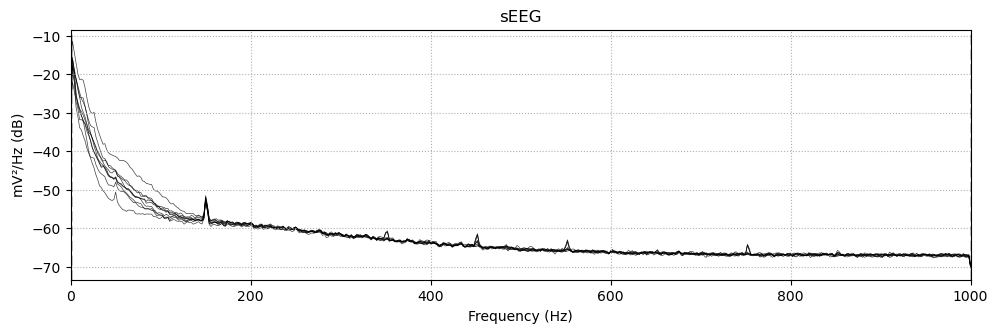

In [9]:
raw_mne_deriv_select.compute_psd(tmax=np.inf, fmax=1000, method='welch', n_overlap = 250, n_fft = 1000).plot()

Effective window size : 4.000 (s)


/tmp/ipykernel_36651/1445351632.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_deriv_select.compute_psd(tmax=np.inf, fmax=100, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True).plot()


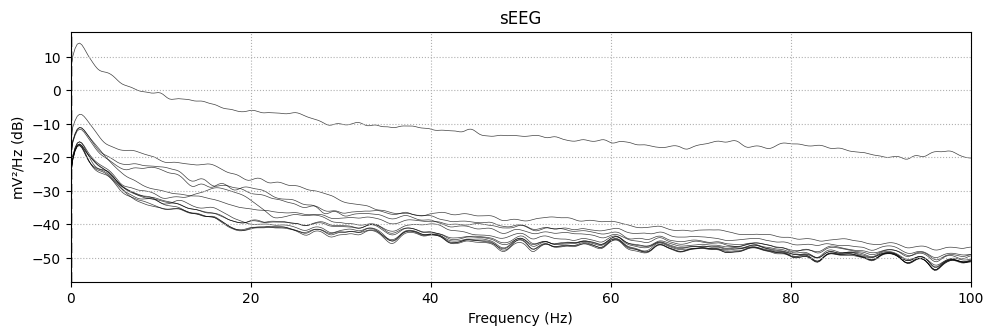

In [11]:
raw_mne_deriv_select.compute_psd(tmax=np.inf, fmax=100, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True).plot()

Effective window size : 4.000 (s)


/tmp/ipykernel_24672/3624533442.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_deriv_select.compute_psd(tmax=np.inf, fmax=30, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True).plot()


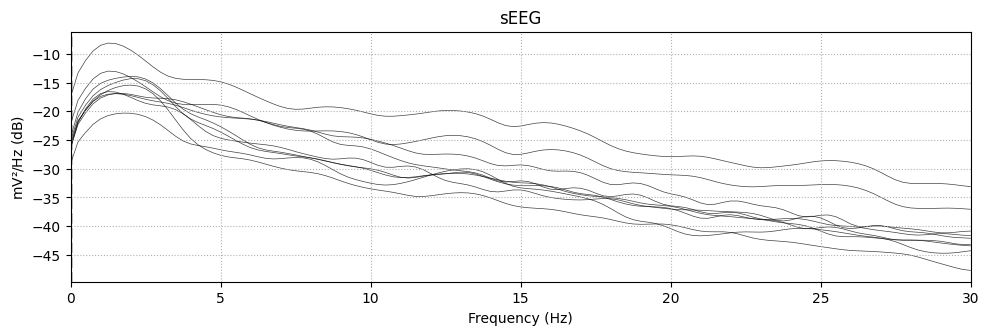

In [11]:
raw_mne_deriv_select.compute_psd(tmax=np.inf, fmax=30, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True).plot()

### Filtrado Notch

In [10]:
freqs = [50, 100, 150, 200, 250]
raw_mne_deriv_select_filt = raw_mne_deriv_select.load_data().copy().notch_filter(freqs=freqs, method='spectrum_fit', filter_length='10s')

Reading 0 ... 601999  =      0.000 ...   301.000 secs...
Removed notch frequencies (Hz):
     50.00 :  531 windows
    100.00 :  531 windows
    150.00 :  531 windows
    200.00 :  531 windows
    249.00 :  531 windows
    250.00 :  531 windows
    251.00 :  531 windows


Effective window size : 4.000 (s)


/tmp/ipykernel_31457/3074387987.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne_deriv_select_filt.compute_psd(tmax=np.inf, fmax=100, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True).plot()


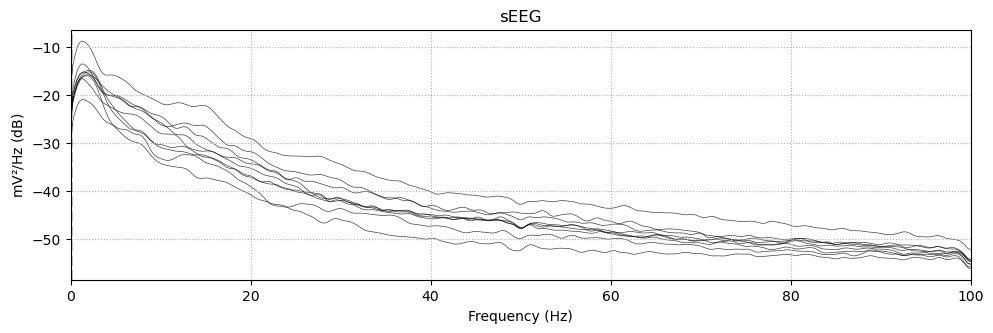

In [11]:
raw_mne_deriv_select_filt.compute_psd(tmax=np.inf, fmax=100, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True).plot()

Grafico de la senial filtrada

Using matplotlib as 2D backend.


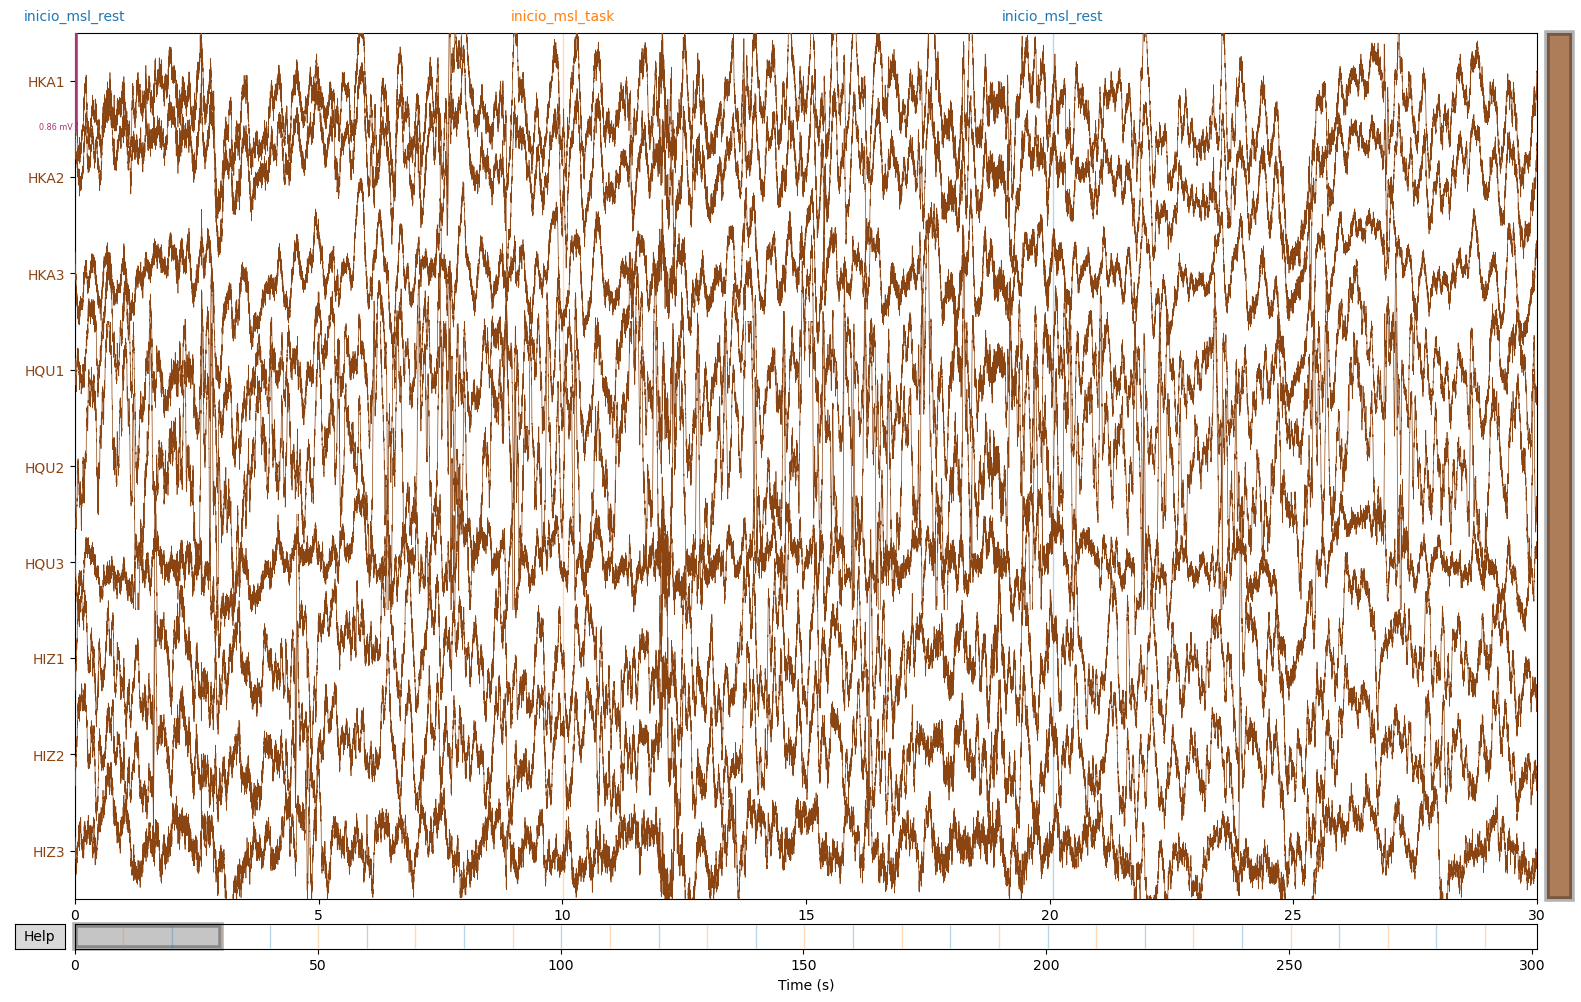

Channels marked as bad:
none


In [12]:
raw_mne_deriv_select_filt.plot(duration=30,remove_dc=False, scalings = 'auto')

Para el caso de los registros control y secuencia pruebo de separar en epocas

Las treas comienzan con un periodo de REST (precedido por un evento/trgger que lo indican) y continuan con un evento de TASK (tambien precedido por un trigger/evento) que lo indica. Cada perido REST/TASK dura 10 segundos y se van danto alternativamente hasta completar 15 de cada uno.

Para eso voy a tomar como punto centrol el trigger del periodo de task y tomar 10 segundos para atras y 10 seg para adelante.

In [25]:
TIME_RANGE = np.array([[-10.0, 10.0],    # epoch
                       [-10.0, 0.0],    # REST
                       [0.0, 10.0]])    # TASK
TIME_RANGE_LABELS = np.array(['epoch',
                              'rest',
                              'task'])

#events_id = {'start_bsl_rest': 64, 'stop_bsl_rest': 128, 'inicio_msl_rest': 4, 'inicio_msl_task': 16}
events_id = {'inicio_msl_task': 16}
events_from_annot, event_dict = mne.events_from_annotations(raw_mne_deriv, event_id=events_id)
#print(events_from_annot)
#print(event_dict)

#
epochs_mne_deriv_select_filt = mne.Epochs(raw_mne_deriv_select_filt, events_from_annot, tmin=TIME_RANGE[0,0], tmax=TIME_RANGE[0,1],
                                          event_id = event_dict, baseline = None)
print(epochs_mne_deriv_select_filt.info)
print(epochs_mne_deriv_select_filt.event_id)

Used Annotations descriptions: ['inicio_msl_task']
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
<Info | 10 non-empty values
 bads: []
 ch_names: HKA1, HKA2, HKA3, HQU1, HQU2, HQU3, HIZ1, HIZ2, HIZ3
 chs: 9 sEEG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2023-02-13 16:36:24 UTC
 nchan: 9
 projs: []
 sfreq: 2000.0 Hz
 subject_info: 3 items (dict)
>
{'inicio_msl_task': 16}


Using data from preloaded Raw for 15 events and 40001 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 10 events and 40001 original time points ...


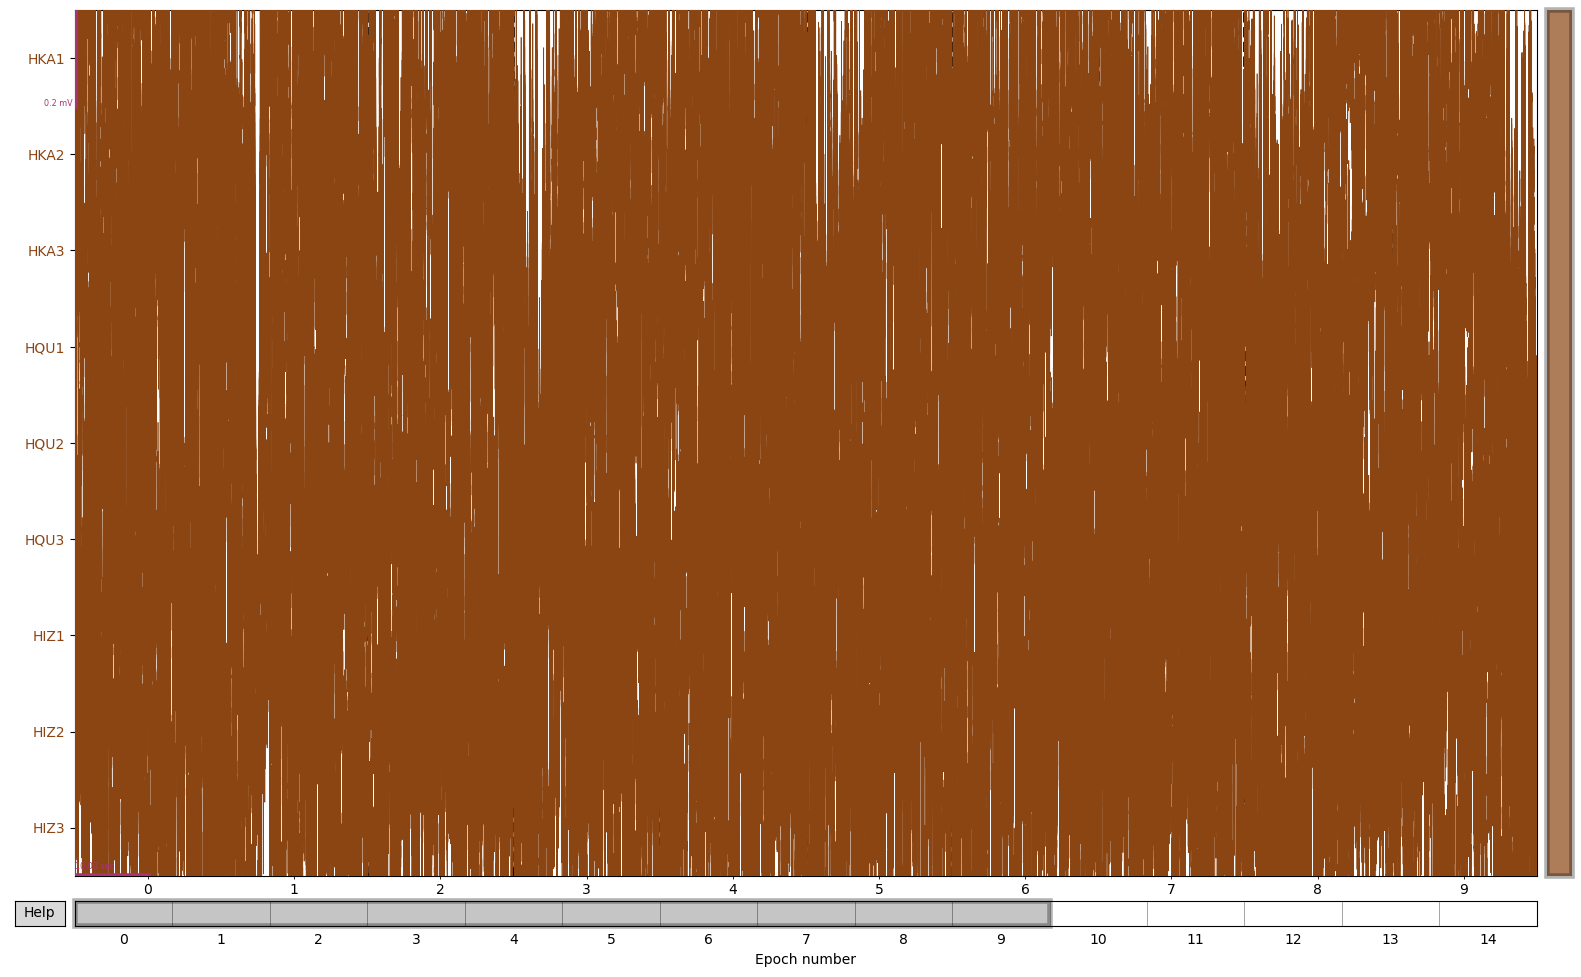

Using data from preloaded Raw for 10 events and 40001 original time points ...
Using data from preloaded Raw for 10 events and 40001 original time points ...
Using data from preloaded Raw for 10 events and 40001 original time points ...
Using data from preloaded Raw for 10 events and 40001 original time points ...
Using data from preloaded Raw for 10 events and 40001 original time points ...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [ ]:
epochs_mne_deriv_select_filt.plot(n_epochs=10)

In [45]:
BANDWIDTH = 2 # multitaper bandwidth
FREQ_RANGE = [0, 100] 
raw_mne_deriv_select_filt_spect = epochs_mne_deriv_select_filt.compute_psd(tmin = TIME_RANGE[1,0], tmax=TIME_RANGE[1,1], 
                                    fmin = FREQ_RANGE[0], fmax = FREQ_RANGE[1], method='multitaper', bandwidth = BANDWIDTH, 
                                    verbose=True).plot()

# calculate PSD
#psd, freq = mne.time_frequency.psd_multitaper(epochs, fmin = FREQ_RANGE[0], fmax = FREQ_RANGE[1], 
#                                              tmin = TIME_RANGE[0,0], tmax = TIME_RANGE[0,1],
#                                        bandwidth = BANDWIDTH, verbose=False)

Using data from preloaded Raw for 15 events and 40001 original time points ...
    Using multitaper spectrum estimation with 19 DPSS windows
Averaging across epochs...


/tmp/ipykernel_31457/1403419888.py:5: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  verbose=True).plot()


In [11]:
#para obtener los datos de Spectrum

raw_mne_deriv_select_filt_spect = raw_mne_deriv_select_filt.compute_psd(tmax=np.inf, fmax=100, method='welch',n_per_seg=2000, n_fft=8000,average="mean", verbose=True)
raw_mne_deriv_select_filt_spect.info['ch_names']
#psds, freqs = spectrum.get_data(exclude=(), return_freqs=True)
#psds = 20 * np.log10(psds)  # scale to dB

Effective window size : 4.000 (s)


['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']

In [12]:
# Para guardar el spectro
spectr_fname = str(deriv_bids_path.root) + '/sub-' + subjects[idx_sub] + '/ses-' + session + '/spectral_fit' + '/sub-' + subjects[idx_sub] + '_ses-' + session + '_desc-'+ desc +'_spectrumPSD'
print(spectr_fname)
# SAVE spectrum
#raw_mne_deriv_select_filt_spect.save(spectr_fname, verbose=True)
# READ spectrum
#raw_mne_deriv_select_filt_spect = mne.time_frequency.read_spectrum(spectr_fname)

/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/ses-day1/spectral_fit/sub-06_ses-day1_desc-baselineSegm1_spectrumPSD


In [13]:
print(type(raw_mne_deriv_select_filt_spect))
print(raw_mne_deriv_select_filt_spect.info['ch_names'])
psds, freqs = raw_mne_deriv_select_filt_spect.get_data(exclude=(), return_freqs=True)
print(psds.shape)
print(freqs.shape)

chan = 8
# Plot PSD
fig, ax = plt.subplots()
ax.plot(freqs, 20*np.log10(psds[chan,:]), 'k', lw=2)
ax.set_title('PSD, chan = ' + raw_mne_deriv_select_filt_spect.info['ch_names'][chan])
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('PSD)');
plt.show()

<class 'mne.time_frequency.spectrum.Spectrum'>
['HKA1', 'HKA2', 'HKA3', 'HQU1', 'HQU2', 'HQU3', 'HIZ1', 'HIZ2', 'HIZ3']
(9, 401)
(401,)


Ajuste del modelo FOOOF a nivel grupan en todos los espectros de 'raw_mne_deriv_select_filt_spect'

In [14]:
fg = FOOOFGroup()
fg.fit(freqs, psds)
#fg.print_results()


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 9 power spectra.


In [15]:
spectr_fit_fname = str(deriv_bids_path.root) + '/sub-' + subjects[idx_sub] + '/ses-' + session + '/spectral_fit' + '/sub-' + subjects[idx_sub] + '_ses-' + session + '_desc-'+ desc +'_spectralFit'
print(spectr_fit_fname)
#fg.save(spectr_fit_fname, save_settings=True, save_results=True)
#fg.load(file_name=spectr_fit_fname)

/home/lfa-01/Documentos/Derivatives_Proyecto_LFA-ENYS_BIDS/sub-06/ses-day1/spectral_fit/sub-06_ses-day1_desc-baselineSegm1_spectralFit


In [16]:
#print(type(fg.get_fooof(0)))
#print(fg.get_settings())
print(len(fg.group_results))

sqrt = np.sqrt(len(fg.group_results))

# Busco los indices en 'y' y 'x' para graficar cada espectro en una misma figura
if sqrt%int(sqrt) == 0:
    max_idx_y = int(sqrt)
    max_idx_x = max_idx_y 
else: 
    max_idx_y = int(np.round(sqrt))
    max_idx_x = int(np.ceil(sqrt))

# Figura
fig1, (ax1) = plt.subplots(max_idx_y,max_idx_x, sharex=True,sharey=True) #
fig2, (ax2) = plt.subplots(max_idx_y,max_idx_x, sharex=True,sharey=True) #

for idx_y in range(max_idx_y):
    for idx_x in range(max_idx_x):
        chan_n = idx_y*max_idx_y + idx_x
        #print(chan_n)
        #print("y:",idx_y)
        #print("x:",idx_x)
        
        fm = fg.get_fooof(chan_n, regenerate=True)
        
        aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
        fm.plot(ax=ax1[idx_y,idx_x],add_legend=False) 
        
        ax1[idx_y,idx_x].plot(freqs,np.log10(psds[chan_n,:]),'k')
        ax1[idx_y,idx_x].set_title(raw_mne_deriv_select_filt_spect.info['ch_names'][chan_n])

        # Espectro suprimiendo la componente 1/f
        ax2[idx_y,idx_x].plot(freqs,np.log10(psds[chan_n,:])-aperiodic,'k')
        ax2[idx_y,idx_x].plot(fm.freqs,fm.fooofed_spectrum_-aperiodic[1:],'r')
        ax2[idx_y,idx_x].set_title(raw_mne_deriv_select_filt_spect.info['ch_names'][chan_n])
        ax2[idx_y,idx_x].axhline(y=0, xmin=np.min(freqs), xmax=np.max(freqs))
        

plt.show()


9
y: 0
x: 0
y: 0
x: 1
y: 0
x: 2
y: 1
x: 0
y: 1
x: 1
y: 1
x: 2
y: 2
x: 0
y: 2
x: 1
y: 2
x: 2


/tmp/ipykernel_17229/3199893558.py:28: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_17229/3199893558.py:28: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_17229/3199893558.py:28: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_17229/3199893558.py:28: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offset') - np.log10(freqs**fm.get_params('aperiodic_params', 'exponent'))
/tmp/ipykernel_17229/3199893558.py:28: RuntimeWarning: divide by zero encountered in log10
  aperiodic = fm.get_params('aperiodic_params', 'offs

In [18]:
fg.plot()
plt.show()

In [50]:
group_peak_params = fg.get_params('peak_params') 
print(np.ones(group_peak_params.shape[0]))
group_peak_params = np.column_stack((group_peak_params, np.ones(group_peak_params.shape[0])))

#group_peak_params[:,4] = 1
print(group_peak_params)
#print(fg.get_params('peak_params').shape)

fig, ax = plt.subplots()
ax.scatter(group_peak_params[:,4],group_peak_params[:,0], c=group_peak_params[:,3])

plt.show()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]
[[ 3.55788556  1.05600854  3.28793664  0.          1.        ]
 [14.76142575  0.7298699  12.          0.          1.        ]
 [ 3.19325208  1.02519322  2.47287709  1.          1.        ]
 [13.92031939  0.70920668 12.          1.          1.        ]
 [ 2.51285791  1.32514526  1.72434305  2.          1.        ]
 [ 6.03674926  0.74394236  4.20595783  2.          1.        ]
 [12.6671047   0.72961414  7.88609426  2.          1.        ]
 [22.40560149  0.49733099 10.83064749  2.          1.        ]
 [12.44339623  0.92205412 11.85738809  3.          1.        ]
 [26.44464713  0.62811788 12.          3.          1.        ]
 [12.4354039   0.94877567 11.07633248  4.          1.        ]
 [26.45928665  0.6136964  12.          4.          1.        ]
 [ 2.74569258  0.64118512  1.47158477  5.          1.        ]
 [ 6.62388828  0.71071534  3.95972581  5.          1.        ]
 [13.8257438   0.91625758  6.06828687  5

/home/lfa-01/anaconda3/envs/test_neo/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


In [14]:
# Initialize a FOOOF object
fm = FOOOF()

# Set the frequency range to fit the model
freq_range = [0.5, 100]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
#fm.fit(freqs, psds[chan,:], freq_range)

fig, (ax) = plt.subplots(3,3, sharex=True,sharey=True)

for idx_y in range(3):
    for idx_x in range(3):
        chan_n = idx_y*3 + idx_x
        #print(chan_n)
        fm.fit(freqs, psds[chan_n,:], freq_range)
        fm.plot(ax=ax[idx_y,idx_x],add_legend=False) 
        ax[idx_y,idx_x].plot(fm.freqs,fm._spectrum_flat)
        ax[idx_y,idx_x].set_title(raw_mne_deriv_select_filt_spect.info['ch_names'][chan_n])
        

plt.show()

In [34]:
fm.print_results()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 0 - 100 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -7.7886, 1.7754                                          
                                                                                                  
                                       2 peaks were found:                                        
          

In [37]:
fg = FOOOFGroup()
fg.fit(freqs, psds)
fg.print_results()


FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 9 power spectra.
                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 9                              
                                                                                                  
                       The model was run on the frequency range 0 - 100 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                 

/home/lfa-01/anaconda3/envs/test_neo/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


In [40]:
fg.plot()
plt.show()

/home/lfa-01/anaconda3/envs/test_neo/lib/python3.10/site-packages/fooof/objs/group.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out = np.array([np.insert(getattr(data, name), 3, index, axis=1)


In [43]:
print(fg.group_results)

[FOOOFResults(aperiodic_params=array([-7.78861704,  1.77536794]), peak_params=array([[ 3.55788556,  1.05600854,  3.28793664],
       [14.76142575,  0.7298699 , 12.        ]]), r_squared=0.9779091226253329, error=0.11213237156217984, gaussian_params=array([[ 3.55788556,  0.93118879,  1.64396832],
       [14.76142575,  0.72987123,  6.        ]])), FOOOFResults(aperiodic_params=array([-7.78853941,  1.78507725]), peak_params=array([[ 3.19325208,  1.02519322,  2.47287709],
       [13.92031939,  0.70920668, 12.        ]]), r_squared=0.983965295418958, error=0.07860252470900207, gaussian_params=array([[ 3.19325208,  0.88022209,  1.23643855],
       [13.92031939,  0.70926922,  6.        ]])), FOOOFResults(aperiodic_params=array([-8.22160787,  1.80688187]), peak_params=array([[ 2.51285791,  1.32514526,  1.72434305],
       [ 6.03674926,  0.74394236,  4.20595783],
       [12.6671047 ,  0.72961414,  7.88609426],
       [22.40560149,  0.49733099, 10.83064749]]), r_squared=0.9913908320632547, error